In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim import corpora, models
import pyLDAvis.gensim_models
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

In [37]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('pos_tag')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Open Multilingual WordNet（用于词形还原）


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
file_path = 'Topic Modeling Articles_0601.xlsx'
df = pd.read_excel(file_path, sheet_name='Topic Modeling Articles')
df['text'] = df['Title'] + ' ' + df['Abstract Note'].fillna('')


In [58]:
# Step 5: Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yangqingyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



=== Automated Topic Analysis ===

Topic 0: Students Gender
Key Terms: students, gender, field, interests, results
Example Papers:
- The career development needs of rural elementary school students...
- Career education at the elementary school level: Student and intern te...

Topic 1: Influence Model
Key Terms: influence, model, guidance, awareness, design
Example Papers:
- Career development learning in childhood: A collaborative guidance app...
- Parental influence on child career development in mainland China: A qu...

Topic 2: Rural Parents
Key Terms: students, science, health, rural, parents
Example Papers:
- The effectiveness of quartet card game in increasing career knowledge ...
- Career Development in Middle Childhood: A Qualitative Inquiry...

Topic 3: Girls Work
Key Terms: girls, work, aspirations, gender, future
Example Papers:
- Girls are better students but boys will be more successful at work: Di...
- A career education program for early childhood youth: Development and

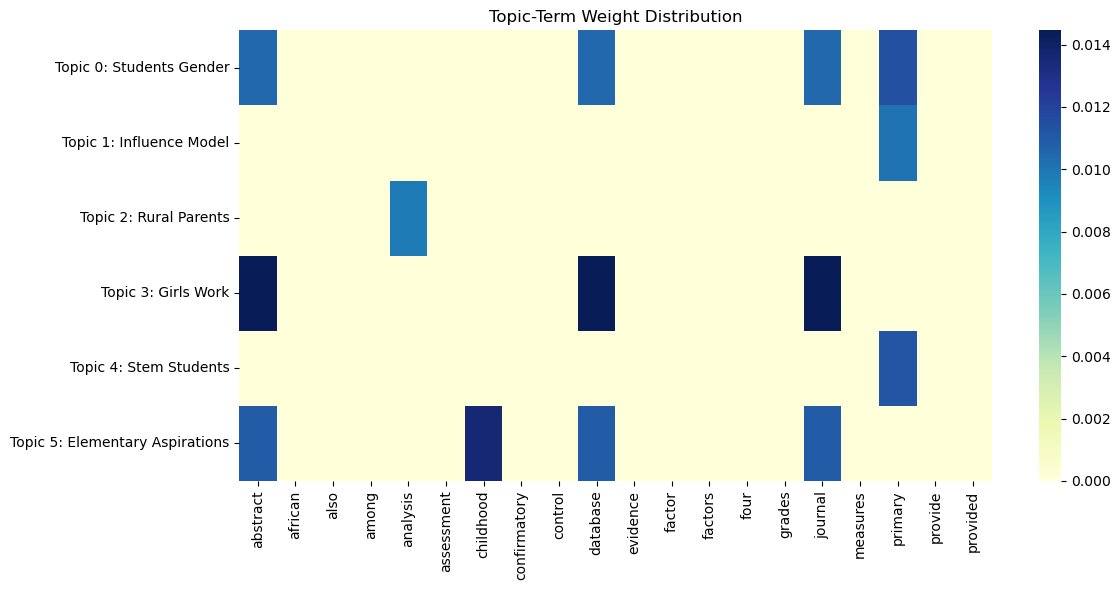

In [65]:
import pandas as pd
import numpy as np
from gensim import corpora, models
import re
from collections import defaultdict
from nltk import pos_tag
from nltk.corpus import stopwords
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# 1. Enhanced preprocessing with domain-specific filtering
domain_stopwords = set(stopwords.words('english')).union({
    'career', 'child', 'development', 'student', 'study', 
    'research', 'school', 'childrens', 'education', 'learning',
    'paper', 'article', 'find', 'result', 'literature'
})

def advanced_preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = [word for word in text.split() 
             if (len(word) > 3 and word not in domain_stopwords)]
    return tokens

df['processed'] = df['text'].apply(advanced_preprocess)

# 2. Build focused dictionary
dictionary = corpora.Dictionary(df['processed'])
dictionary.filter_extremes(no_below=5, no_above=0.6)
corpus = [dictionary.doc2bow(text) for text in df['processed']]

# 3. Automated topic label generation
def generate_topic_label(terms):
    """Generate human-readable topic labels using NLP patterns"""
    # Extract top 5 terms with highest weights
    top_terms = [term.split('*')[1].strip('"') for term in terms.split(' + ')[:5]]
    
    # POS tagging for meaningful combinations
    tagged = pos_tag(top_terms)
    
    # Pattern 1: Adjective + Noun (e.g., "Gender Differences")
    adj_nouns = []
    for i in range(len(tagged)-1):
        if tagged[i][1].startswith('JJ') and tagged[i+1][1].startswith('NN'):
            adj_nouns.append(f"{tagged[i][0]} {tagged[i+1][0]}")
    
    if adj_nouns:
        return adj_nouns[0].title()
    
    # Pattern 2: Noun + Noun (e.g., "STEM Education")
    noun_phrases = []
    current_phrase = []
    for word, pos in tagged:
        if pos.startswith('NN'):
            current_phrase.append(word)
        else:
            if len(current_phrase) >= 2:
                noun_phrases.append(" ".join(current_phrase))
            current_phrase = []
    
    if noun_phrases:
        return noun_phrases[0].title()
    
    # Fallback: First two terms capitalized
    return " ".join([tagged[i][0].title() for i in range(min(2, len(tagged)))])

# 4. Run optimized LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=6,
    random_state=42,
    passes=20,
    alpha='asymmetric',
    eta=0.7,
    iterations=400
)

# 5. Generate and display enhanced topic report
print("\n=== Automated Topic Analysis ===")
topic_labels = {}
for idx in range(lda_model.num_topics):
    topic_terms = lda_model.print_topic(idx)
    label = generate_topic_label(topic_terms)
    topic_labels[idx] = label
    
    # Get top 5 terms (excluding generic terms)
    terms = [term.split('*')[1].strip('"') 
            for term in topic_terms.split(' + ')
            if term.split('*')[1].strip('"') not in domain_stopwords][:5]
    
    print(f"\nTopic {idx}: {label}")
    print("Key Terms:", ", ".join(terms))
    
    # Show representative documents
    doc_topics = [max(lda_model[doc], key=lambda x: x[1])[0] 
                 for doc in corpus]
    sample_titles = df.iloc[[i for i, t in enumerate(doc_topics) 
                           if t == idx]]['Title'].head(2)
    print("Example Papers:")
    for title in sample_titles:
        print(f"- {title[:70]}...")

# 6. Visualize topic-term relationships
topic_term_matrix = np.zeros((lda_model.num_topics, len(dictionary)))
for i in range(lda_model.num_topics):
    for term_id, weight in lda_model.get_topic_terms(i, topn=15):
        topic_term_matrix[i, term_id] = weight

plt.figure(figsize=(12, 6))
sns.heatmap(topic_term_matrix[:, :20],  # Show first 20 terms for clarity
            xticklabels=[dictionary[i] for i in range(20)],
            yticklabels=[f"Topic {i}: {topic_labels[i]}" 
                        for i in range(lda_model.num_topics)],
            cmap="YlGnBu")
plt.title("Topic-Term Weight Distribution")
plt.tight_layout()
plt.show()
def get_dominant_topic(lda_model, corpus):
    topic_dist = []
    for doc in corpus:
        topic_dist.append(lda_model.get_document_topics(doc))
    dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_dist]
    return dominant_topics

df['dominant_topic'] = get_dominant_topic(lda_model, corpus)

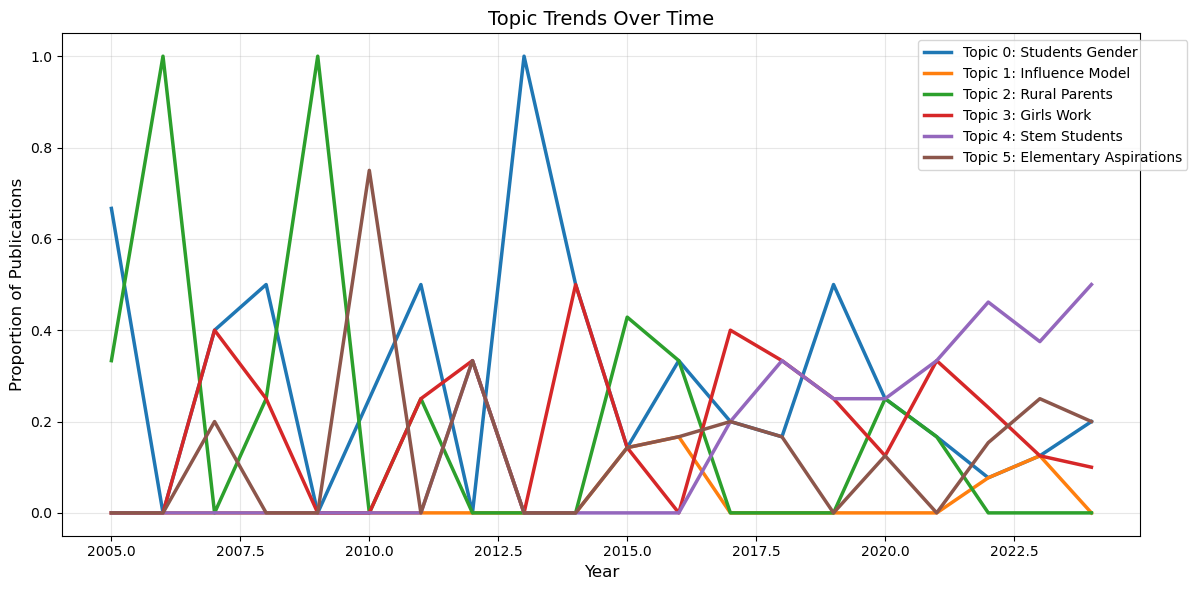


=== Topic Trend Analysis ===
 Topic                  Label      Trend     Slope
     4          Stem Students Increasing  0.025412
     3             Girls Work Increasing  0.005078
     1        Influence Model Increasing  0.002949
     5 Elementary Aspirations Increasing  0.002350
     0        Students Gender Decreasing -0.010986
     2          Rural Parents Decreasing -0.024803

=== Key Findings ===
Increasing Topics: Stem Students, Girls Work, Influence Model, Elementary Aspirations
Decreasing Topics: Students Gender, Rural Parents
Stable Topics: 


In [66]:
import matplotlib.pyplot as plt
from scipy.stats import linregress

# 确保有Publication Year列且是数值类型
df['Publication Year'] = pd.to_numeric(df['Publication Year'], errors='coerce')
df = df.dropna(subset=['Publication Year'])

# 为每篇文章分配主要主题
def get_dominant_topic(doc):
    topic_dist = lda_model[doc]
    return max(topic_dist, key=lambda x: x[1])[0] if topic_dist else -1

df['dominant_topic'] = [get_dominant_topic(doc) for doc in corpus]

# 计算每年各主题比例
topic_by_year = df.groupby(['Publication Year', 'dominant_topic']).size().unstack(fill_value=0)
topic_by_year = topic_by_year.div(topic_by_year.sum(axis=1), axis=0)

# 1. 主题随时间变化可视化
plt.figure(figsize=(12, 6))
for topic in topic_by_year.columns:
    plt.plot(topic_by_year.index, topic_by_year[topic], 
             label=f'Topic {topic}: {topic_labels[topic]}',
             linewidth=2.5)
plt.title('Topic Trends Over Time', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Publications', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. 计算趋势斜率
trend_results = []
for topic in topic_by_year.columns:
    slope, intercept, r_value, p_value, std_err = linregress(
        topic_by_year.index, 
        topic_by_year[topic]
    )
    trend_results.append({
        'Topic': topic,
        'Label': topic_labels[topic],
        'Slope': slope,
        'Trend': 'Increasing' if slope > 0.001 else 
                'Decreasing' if slope < -0.001 else 'Stable',
        'P-value': p_value
    })

# 转换为DataFrame并排序
trend_df = pd.DataFrame(trend_results).sort_values('Slope', ascending=False)

# 打印趋势分析结果
print("\n=== Topic Trend Analysis ===")
print(trend_df[['Topic', 'Label', 'Trend', 'Slope']].to_string(index=False))

# 3. 识别关键趋势
increasing_topics = trend_df[trend_df['Trend'] == 'Increasing']['Label'].tolist()
decreasing_topics = trend_df[trend_df['Trend'] == 'Decreasing']['Label'].tolist()
stable_topics = trend_df[trend_df['Trend'] == 'Stable']['Label'].tolist()

print("\n=== Key Findings ===")
print(f"Increasing Topics: {', '.join(increasing_topics)}")
print(f"Decreasing Topics: {', '.join(decreasing_topics)}")
print(f"Stable Topics: {', '.join(stable_topics)}")